# 3D Gan

![3D Gan Output](./output/3dgan/combined.png)

In this notebook I implemented the 3D GAN proposed by Wu et al. ([see the paper](http://3dgan.csail.mit.edu/papers/3dgan_nips.pdf)). 

## Data

For the data, I used the [binvox](https://www.patrickmin.com/binvox/) tool to convert the off files from ModelNet10 to binvox files, and then I used the [binvox-rw-python](https://github.com/dimatura/binvox-rw-py) script to load the binvox files into python as numpy arrays. I adopted this approach as on the [ShapeNet Annotations](https://www.shapenet.org/annotations) site, it was mentioned that they followed this procedure for their voxelization.

**Note**: This differs from the original paper, as they trained on ShapeNet. However, they did not mention how they voxelized the .obj files.

## Models

Let CBk be a sequence of a convolution layer with output features maps k, batch normalisation, and a ReLU. Let Ck be the same without batch normalisation. For the Discriminator, let the ReLUs be LeakyReLUs with slope 0.2. Lastly, let Ck_sig be the same as before but with the sigmoid function as activation instead of ReLU.

I followed the architectures proposed in the original paper:

**Generator**: CB512 - CB256 - CB128 - CB64 - C1_sig with kernel sizes of 4 and strides of 1 (first one) and 2 (rest).

**Discriminator**: CB64 - CB128 - CB256 - CB512 - C1_sig with kernel sizes 4 and strides of 2 (all except the last one) and 1 (last layer)

## Training

For training, I used a batch size of 32 and 200 epochs. I used learning rates of 0.0025 (generator) and 10^-4 (discriminator). 

**Note**: In the original paper, they used a learning rate of 10^-5 for the discriminator and the policy to only perform a discriminator update if the accuracy before was below 80%. I did not implement this in my script as it produced unstable training for me.

## Output

The networks co-domain is (0,1), so that the output needs to be transformed to be a valid occupancy grid with values of 0 and 1. In the original paper, they did not mention how they did that. I implemented the obvious rule to set all values <= 0.5 to 0 and all values > 0.5 to 1.

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torchvision import transforms, utils
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import binvox_rw

In [78]:
root_dir = './data/Shape_Generation/chair_train_binvox/'

batch_size = 128

z_dim = 200

ngf = 64
ndf = 64

num_epochs = 30

show_images = False

r1_regulariser = 1.0

n_gpu = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() and n_gpu>0 else "cpu")
print("Running on {} GPUs.".format(n_gpu) if n_gpu>0 else "Running on CPU.")

Running on 1 GPUs.


## Data set

I assume that the .binvox files are provided in the root_dir.

In [3]:
class VoxelDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        super(VoxelDataset, self).__init__()
        self.transforms = transforms
        self.file_list = os.listdir(root_dir)
        self.voxel_list = []
        for f in self.file_list:
            f = os.path.join(root_dir, f)
            with open(f, 'rb') as f:
                model = binvox_rw.read_as_3d_array(f)
            
            self.voxel_list.append(model.data.astype(float))
                
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        x = self.voxel_list[idx]
        x = torch.Tensor(x).float()
        return x

In [4]:
dataset = VoxelDataset(root_dir)

In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Let's have a look at an example data point.

In [6]:
if show_images:
    example_batch = next(iter(dataloader))
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection="3d")
    ax.voxels(np.transpose(example_batch[1].numpy(), (0,1,2)), edgecolor='k')
    plt.show()

## Models

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose3d(z_dim, ngf*8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm3d(ngf*8),
            nn.ReLU(), # 4x4x4
            nn.ConvTranspose3d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ngf*4),
            nn.ReLU(), # 8x8x8
            nn.ConvTranspose3d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ngf*2),
            nn.ReLU(), # 16^3
            nn.ConvTranspose3d(ngf*2, ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ngf),
            nn.ReLU(), # 32^3
            nn.ConvTranspose3d(ngf, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # 64^3
        )
    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], 1, 1, 1)
        x = self.main(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[3], x.shape[4])
        return x

In [8]:
netG = Generator().to(device)

Example output of random noise

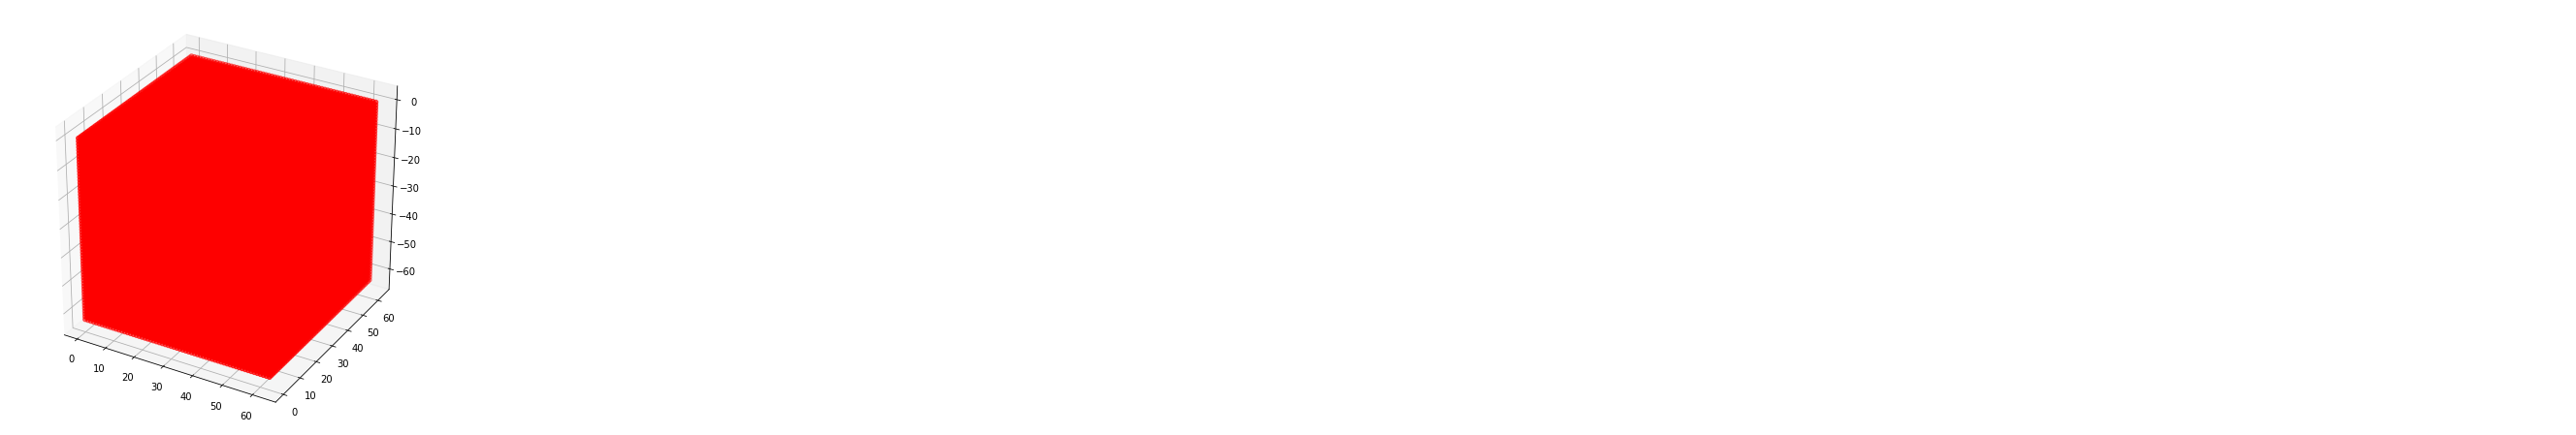

In [41]:
if show_images:
    z = torch.randn(2, z_dim, 1, 1, 1)
    z = z.to(device)
    example_batch = netG(z).detach().cpu().numpy()
    x, y, z = example_batch[0].nonzero()
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, -z, zdir='z', c='red')
    #ax = fig.gca(projection="3d")
    #ax.voxels(np.transpose(example_batch[0], (1,2,0)), edgecolor='k')
    plt.show()

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv3d(1, ndf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ndf),
            nn.LeakyReLU(negative_slope=0.2), #32^3
            nn.Conv3d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ndf*2),
            nn.LeakyReLU(negative_slope=0.2), #16^3
            nn.Conv3d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ndf*4),
            nn.LeakyReLU(negative_slope=0.2), #8^3
            nn.Conv3d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(ndf*8),
            nn.LeakyReLU(negative_slope=0.2), #4^3
            nn.Conv3d(ndf*8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2], x.shape[3])
        x = self.main(x)
        return x

In [11]:
netD = Discriminator().to(device)

In [12]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)  

In [13]:
buffer = netD.apply(init_weights)
buffer = netG.apply(init_weights)

In [14]:
if n_gpu > 1:
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

## Training

In [15]:
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [89]:
num_batches_per_epoch = len(dataloader)
prev_acc = 0
l2_reg = 0

In [95]:
#if os.path.isfile('./models/3dgan_g.pt') and os.path.isfile('./models/3dgan_d.pt'):
if False:
    netG.load_state_dict(torch.load('./models/3dgan_g.pt'))
    netD.load_state_dict(torch.load('./models/3dgan_d.pt'))
    print('Models loaded from file.')
else:    
    for epoch in range(num_epochs):
        print('#'*20, 'Epoch {}/{}'.format(epoch+1, num_epochs), '#'*20)
        for i, data in enumerate(dataloader):
            b_since = time.time()
            data = data.to(device)
            z = torch.randn(batch_size, z_dim, 1, 1, 1)
            z = z.to(device)
            g_output = netG(z)

            #if prev_acc < 0.8:
            if True:
                d_real = netD(data)
                acc_real = np.sum(d_real.detach().cpu().numpy() > 0.5) / batch_size
                D_x = d_real.detach().mean().cpu().numpy()
                d_fake = netD(g_output.detach())
                acc_fake = np.sum(d_fake.detach().cpu().numpy() > 0.5) / batch_size
                prev_acc = (acc_real + acc_fake)/2
                D_z = d_fake.detach().mean().cpu().numpy()
                prev_dz = D_z
                real_loss = criterion(d_real, torch.full_like(d_real, 1, device=device))
                fake_loss = criterion(d_fake, torch.full_like(d_fake, 0, device=device))
                if epoch>0 or i>0:
                    l2_reg = 0
                    for params in netD.parameters():
                         l2_reg += torch.sum(torch.pow(params.grad.data,2))
                    l2_reg = torch.sqrt(l2_reg)
                d_loss = real_loss + fake_loss + r1_regulariser/2 * l2_reg

                netD.zero_grad()
                d_loss.backward()
                
                optimizerD.step()

            # Generator update
            d_fake = netD(g_output)
            g_loss = criterion(d_fake, torch.full_like(d_fake, 1, device=device))
            netG.zero_grad()
            g_loss.backward()
            optimizerG.step()

            b_time = time.time() - b_since
            #if i%7 == 0:
            print('Batch {}/{} \t D_x: {} \t D_z: {} \t D-Acc: {} \n Time: {}'.format(i+1, num_batches_per_epoch, D_x, D_z, prev_acc, round(b_time, 2)))
            
    if(n_gpu > 1):
        torch.save(netG.module.state_dict(), './models/3dgan_g.pt')
        torch.save(netD.module.state_dict(), './models/3dgan_d.pt')
        print('Model saved.')
    else:
        torch.save(netG.state_dict(), './models/3dgan_g.pt')
        torch.save(netD.state_dict(), './models/3dgan_d.pt')
        print('Model saved.')

#################### Epoch 1/200 ####################
Batch 1/6 	 D_x: 0.9721781015396118 	 D_z: 0.038692228496074677 	 D-Acc: 0.5 
 Time: 1.07
tensor(154.4339, device='cuda:0')
Batch 2/6 	 D_x: 0.9929330945014954 	 D_z: 0.030334219336509705 	 D-Acc: 0.5 
 Time: 1.53
tensor(155.6015, device='cuda:0')
Batch 3/6 	 D_x: 0.9872789978981018 	 D_z: 0.02743697538971901 	 D-Acc: 0.5 
 Time: 1.53


Process Process-164:
Process Process-161:
Process Process-163:
Process Process-162:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/is/sg/mniemeyer/anaconda3/envs/pytorch_tutorial/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/is/sg/mniemeyer/anaconda3/envs/pytorch_tutorial/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/is/sg/mniemeyer/anaconda3/envs/pytorch_tutorial/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/is/sg/mniemeyer/anaconda3/envs/pytorch_tutorial/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/is/sg/mniemeyer/anaconda3/envs/pytorch_tutorial/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/is/sg/mniemeyer/.local/lib

KeyboardInterrupt: 

Saved result image 0
Saved result image 1
Saved result image 2
Saved result image 3
Saved result image 4
Saved result image 5
Saved result image 6
Saved result image 7
Saved result image 8
Saved result image 9


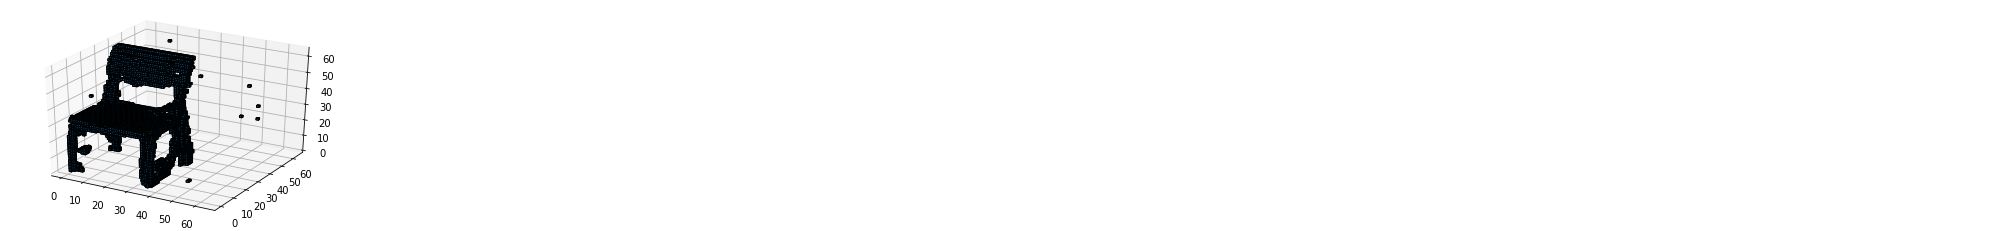

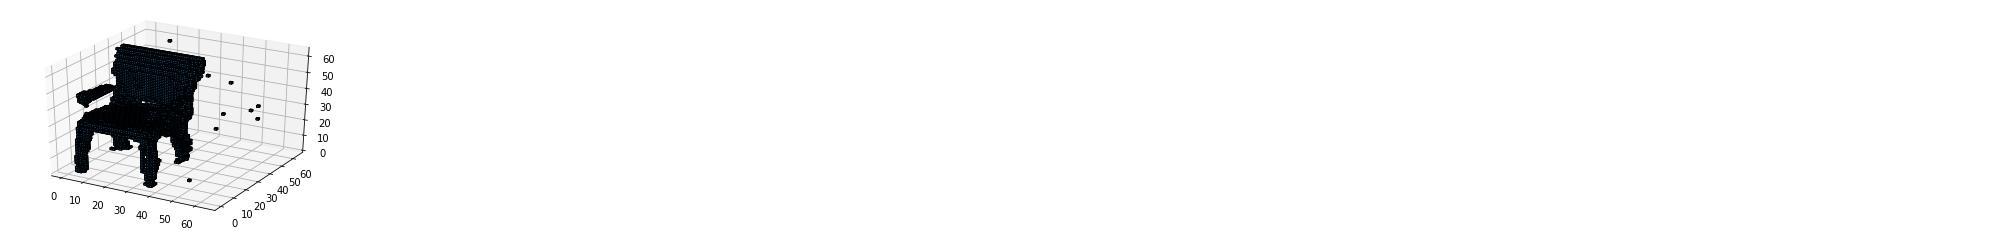

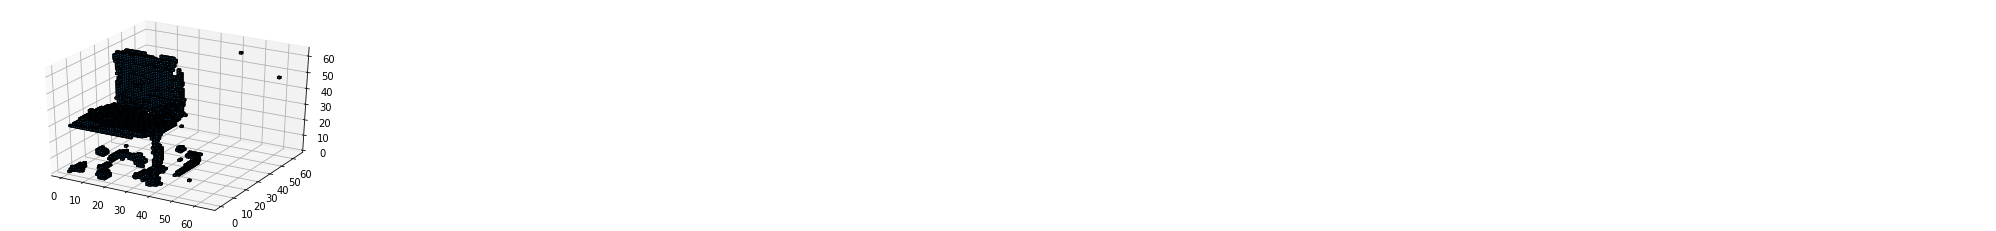

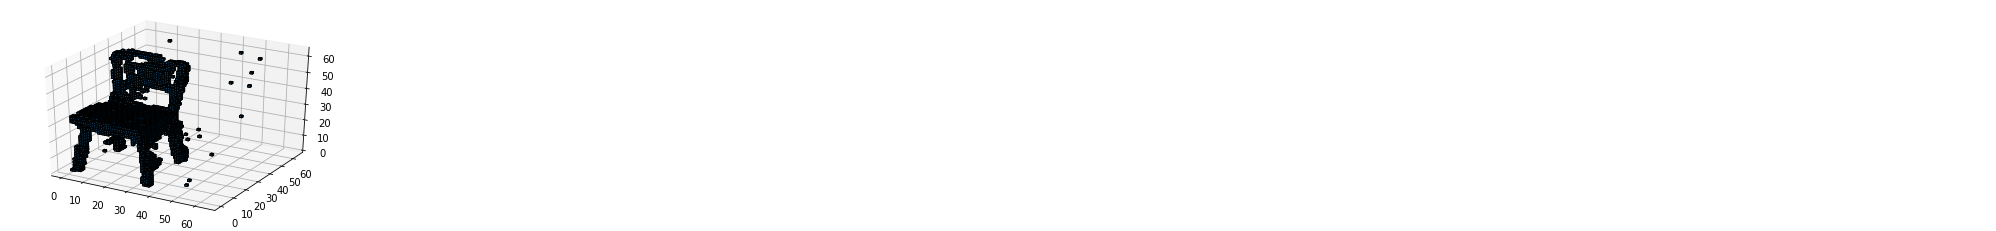

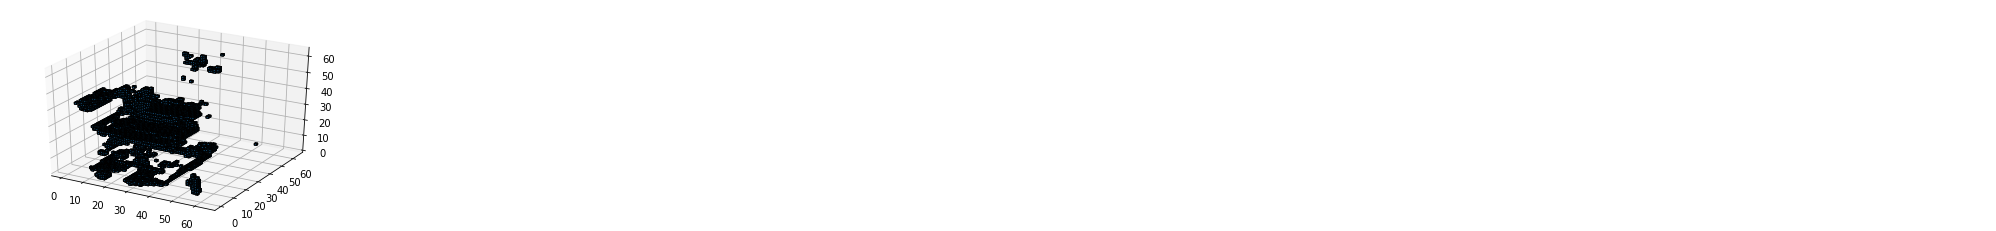

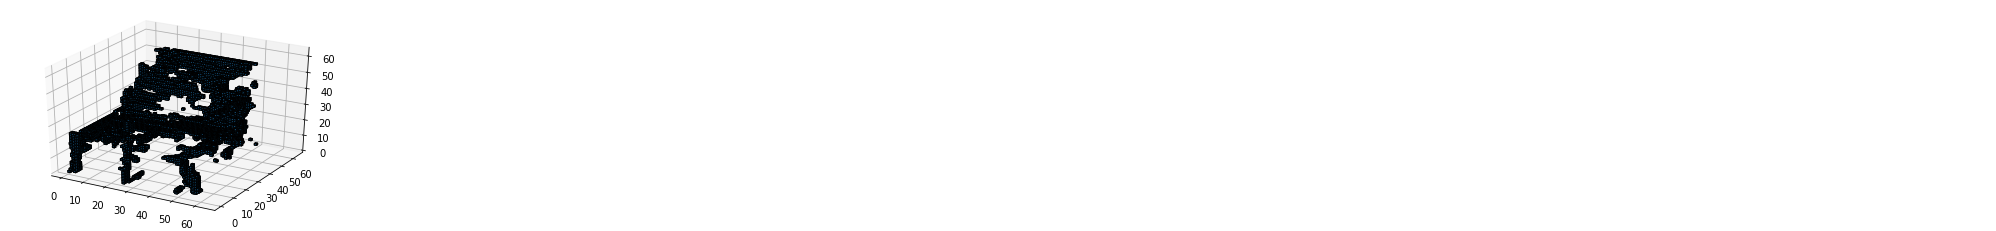

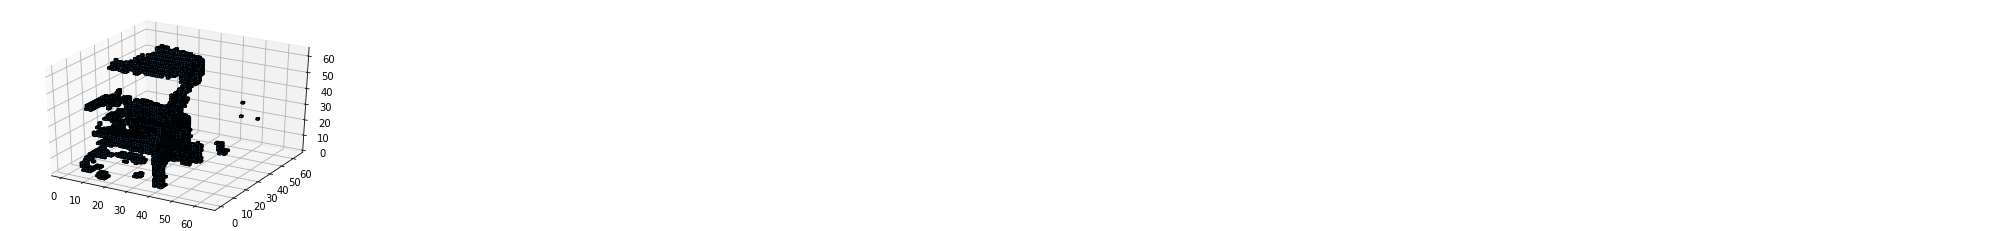

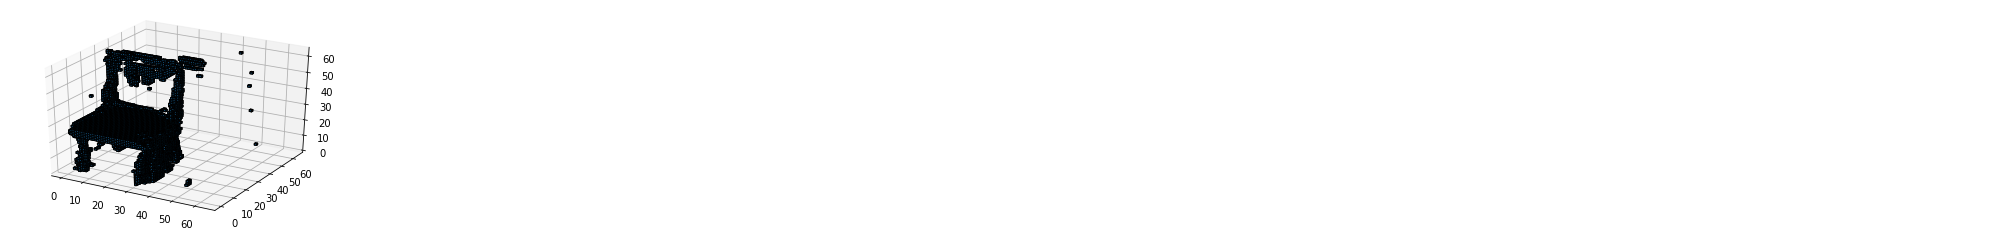

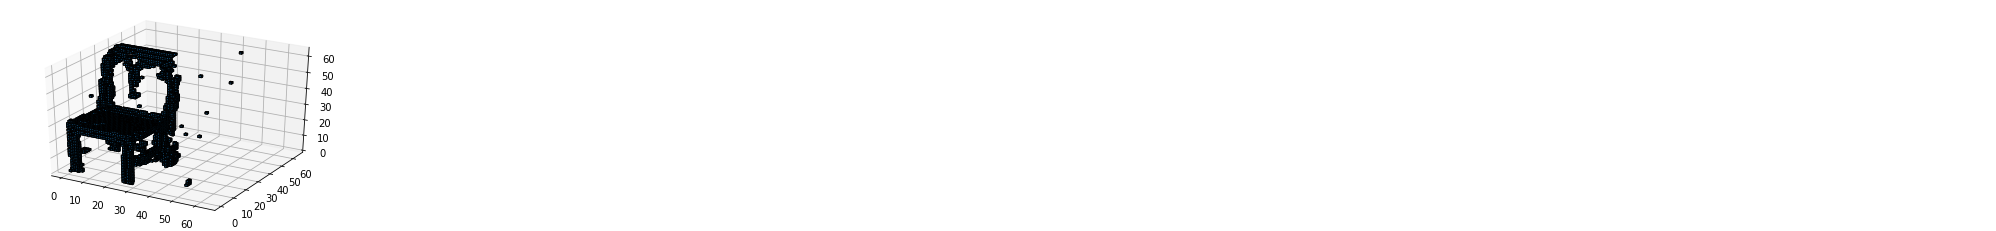

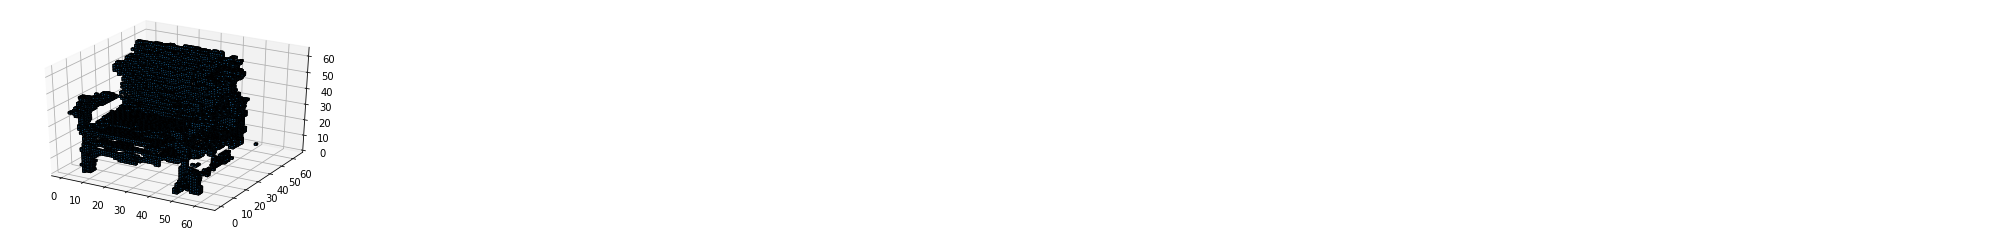

In [77]:
z = torch.randn(10, z_dim, 1, 1, 1)
z = z.to(device)
u = netG(z).detach().cpu().numpy()
bo = np.zeros_like(u)
bo[u>0.5] = 1
example_batch = bo
    
for i in range(10):
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.voxels(example_batch[i], edgecolor='k')
    fig.savefig('./output/3dgan/result2_'+str(i)+'.png')
    print('Saved result image {}'.format(i))